# Time Series Anomaly Detection 
### LSTM Autoencoders with PyTorch

In [135]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import copy
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import os
import zipfile
from torch import nn, optim
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 12, 8
sns.set_style('white')

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [136]:
!nvidia-smi
print('Cuda available:', torch.cuda.is_available())

Wed Oct 30 15:00:34 2024       Cuda available: True

+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.09                 Driver Version: 532.09       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A1000 Laptop GPU   WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8                4W /  N/A|   1084MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----


#### Use case introduction

Electrocardiograms (ECGs) are a critical tool in diagnosing and monitoring cardiac health, as they provide a detailed record of the heart’s electrical activity. 

Manually analyzing ECG data for anomalies, such as arrhythmias or other abnormal heart rhythms, is time-consuming and prone to error due to the volume of data and subtle variations that might signal serious conditions. To address this challenge, artificial intelligence (AI), specifically machine learning (ML) and deep learning (DL) models, have emerged as tools for automatically detecting anomalies in ECG data with high accuracy and efficiency. By leveraging these AI models, healthcare providers can significantly improve the speed and accuracy of diagnostics. AI-based anomaly detection can enhance patient outcomes by identifying conditions that might otherwise be missed in manual analysis, and it can facilitate continuous monitoring in both clinical and remote healthcare settings.

In this use case, we explore how AI-driven anomaly detection models analyze ECG waveforms, recognizing patterns that deviate from normal cardiac activity. 

Note: This model only detect arrhythmias but can later be fine-tuned to classify specific types of cardiac irregularities, enabling a more targeted approach to patient care. The potential of AI in ECG anomaly detection lies in its ability to process vast amounts of complex data rapidly, improve diagnostic precision, and ultimately support clinicians in delivering better, faster, and more personalized care.

#### Data
The dataset contains 5,000 heartbeat samples with 140 timesteps. Each sample corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG) checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart.

We have 5 types of hearbeats (classes):

- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each heartbeat takes about 0.8 seconds to complete the cycle. With these samples, each timestep would be around 5 ms (0.8 / 140 = 0.005 s = 5 ms)

#### Steps
- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

# -

- AI-Driven ECG Analysis: Automates the detection of cardiac anomalies, enhancing diagnostic speed.
- Increased Accuracy: Reduces human error by identifying subtle irregularities in heart rhythms.
- Timely Interventions: Enables real-time monitoring, improving patient outcomes and personalized care.


### Step 1 - import, prepare and explore the data

We will fetch the data, prepare it into the required structure and datatypes, and explore the data using visualizations in order to get a handle of the data we are working with.

In [137]:

# Import the donloaded data
path = os.getcwd()
filepath = os.path.join(path, 'ECG5000.zip')
with zipfile.ZipFile(filepath, 'r') as zipf:
    zipf.extractall('ECG5000')

# Structure the training data and testing data into dataframes
train_data = arff.loadarff(os.path.join(path, 'ECG5000/ECG5000_TRAIN.arff'))
train_df = pd.DataFrame(train_data[0])
train_df['target'] = pd.to_numeric(train_df['target'])

test_data = arff.loadarff(os.path.join(path, 'ECG5000/ECG5000_TEST.arff'))
test_df = pd.DataFrame(test_data[0])
test_df['target'] = pd.to_numeric(test_df['target'])

print('Shape of training dataset: {} - shape of testing dataset: {}'. format(train_df.shape, test_df.shape))

Shape of training dataset: (500, 141) - shape of testing dataset: (4500, 141)


We see that the training dataset consists of 500 records, while the testing dataset consists of the remaining 4500 records. 

Text(0.5, 1.0, 'Class distribution in training data')

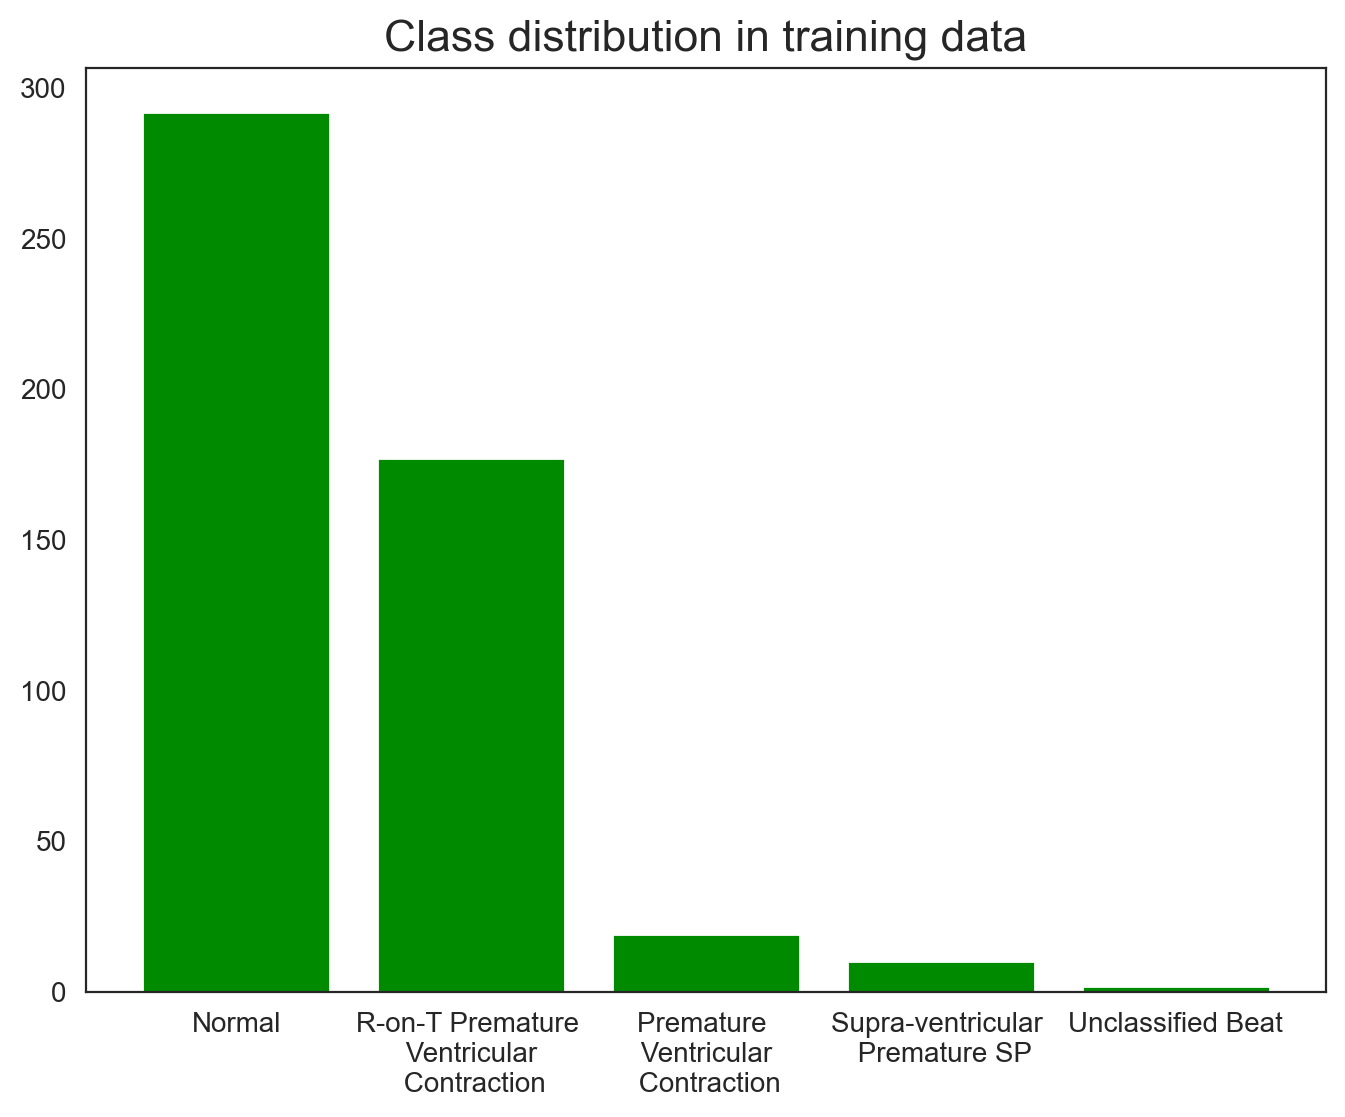

In [138]:
# Explore data
class_normal = 1 
class_abbrv = ['Normal','R on T','PVC','SP','UB']
class_names = [
    'Normal',
    'R-on-T Premature \n Ventricular \n Contraction',
    'Premature \n Ventricular \n Contraction',
    'Supra-ventricular \n Premature SP',
    'Unclassified Beat'
]
# The normal class will be labeled as '1' in the data.
fig = plt.figure(figsize=(8,6))
plt.bar(class_names, train_df['target'].value_counts(), color='#008A00')
plt.title('Class distribution in training data', fontsize=16)

We would like to know more about the shapes of the heartwaves in the different classes. We can study the general structure of the data on a class basis with the following functions:

- We can add extracted heartbeats sequentially, to see the 'flow' of the data and see that it looks somewhat realistic.
- We can analyze the average values per class, and the deviation from the average

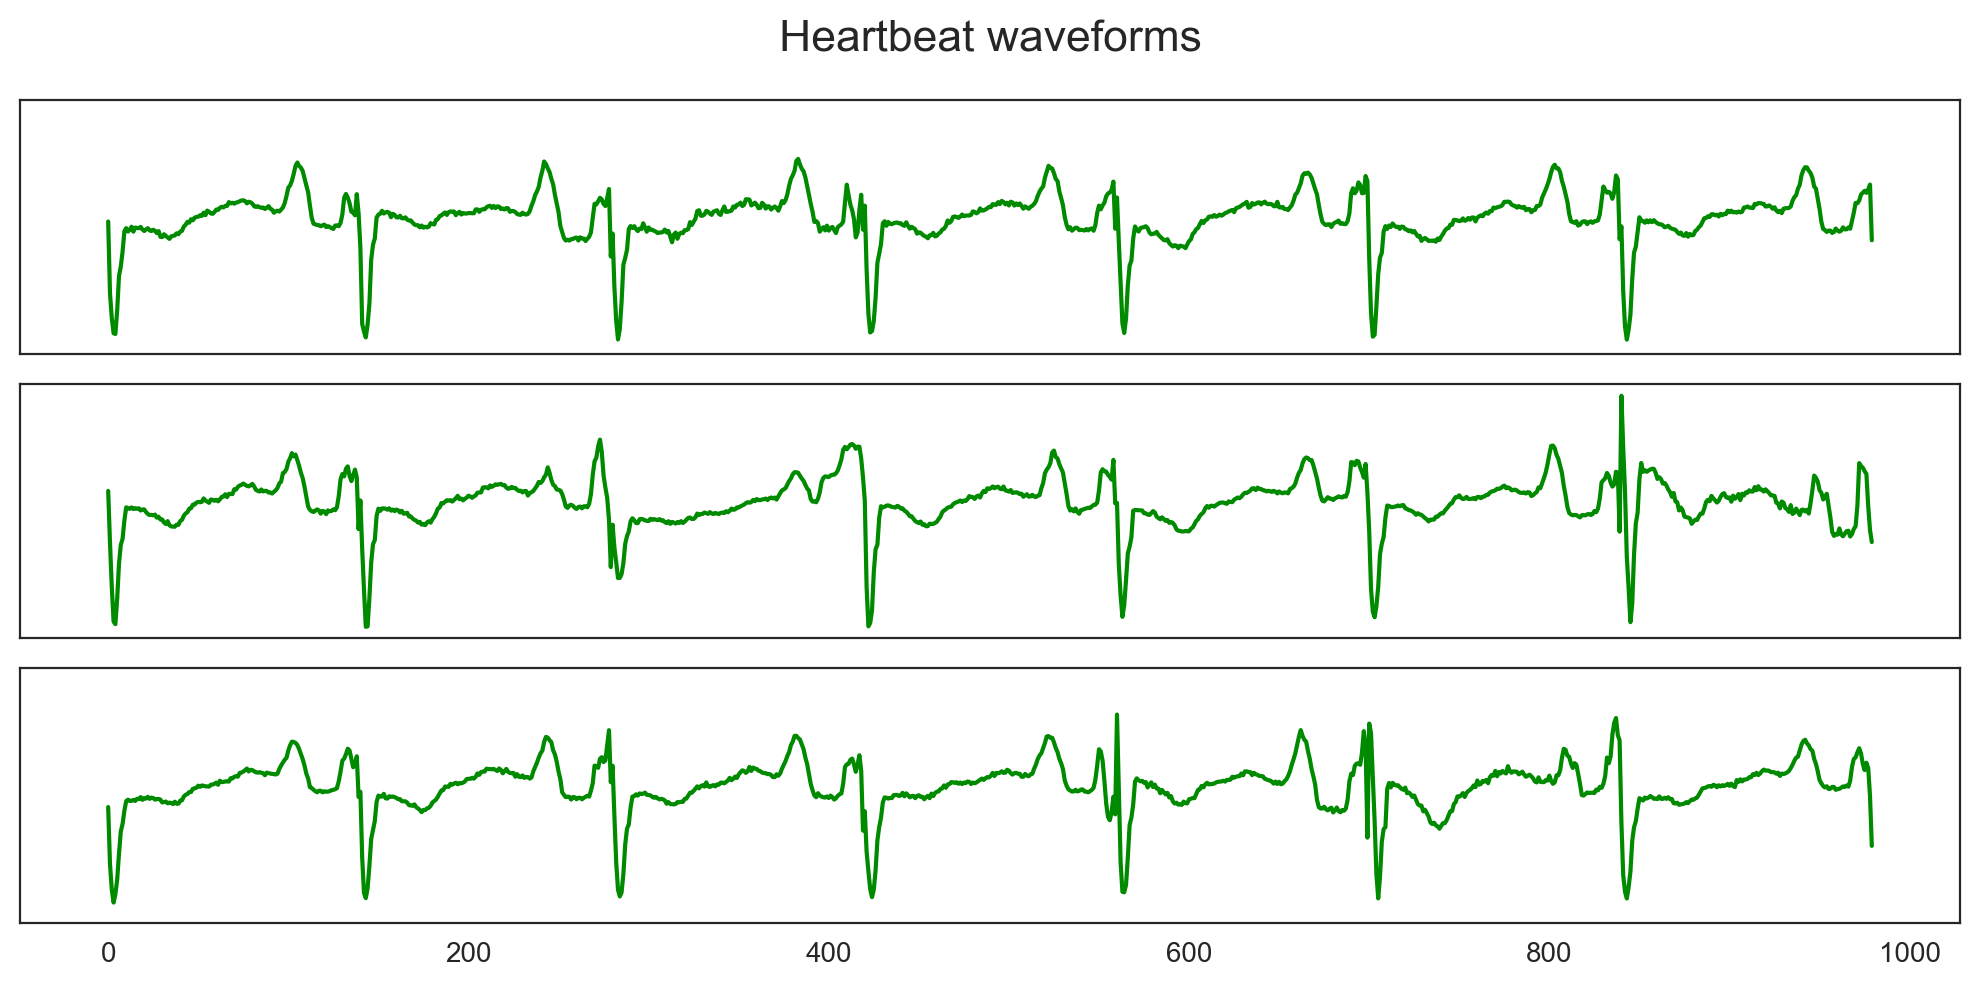

In [139]:
def plot_timeseries_in_rows(data, N):
    # Step 1: Determine the number of elements per row
    chunk_size = int(np.ceil(len(data) / N))
    
    # Step 2: Create N subplots (N rows, 1 column)
    fig, axes = plt.subplots(N, 1, figsize=(10, 5), sharex=True, sharey=True)
    plt.suptitle('Heartbeat waveforms', size=16)
    
    # If there's only one row, `axes` won't be a list, so we ensure it is
    if N == 1:
        axes = [axes]
    
    # Step 3: Plot each segment of the data into its respective subplot
    for i in range(N):
        # Get the segment of data for the current subplot
        segment = data.iloc[i*chunk_size:(i+1)*chunk_size, :].to_numpy().flatten()
        
        # Plot in the current axis
        axes[i].plot(segment, color='#008A00')
        # Remove the box (spines) around each subplot
        # axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    
    # Step 4: Display the plot
    plt.tight_layout()
    plt.show()
attributes = train_df.loc[:20, train_df.columns != 'target']
plot_timeseries_in_rows(attributes, N=3)  # User can specify N here

In [140]:
def class_analysis(data, class_name, ax):
  # Get the data and define the number of steps in smoothing the data
  df = pd.DataFrame(data)
  n_steps=5
  # Calculate the smoothed average and the standard deviation
  smoothed_data = df.rolling(n_steps).mean()
  path_deviation = 2 * df.rolling(n_steps).std()
  
  under_line = (smoothed_data - path_deviation)[0]
  over_line = (smoothed_data + path_deviation)[0]
  # Plot the figures
  ax.plot(smoothed_data, linewidth=2, color='#008A00')
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

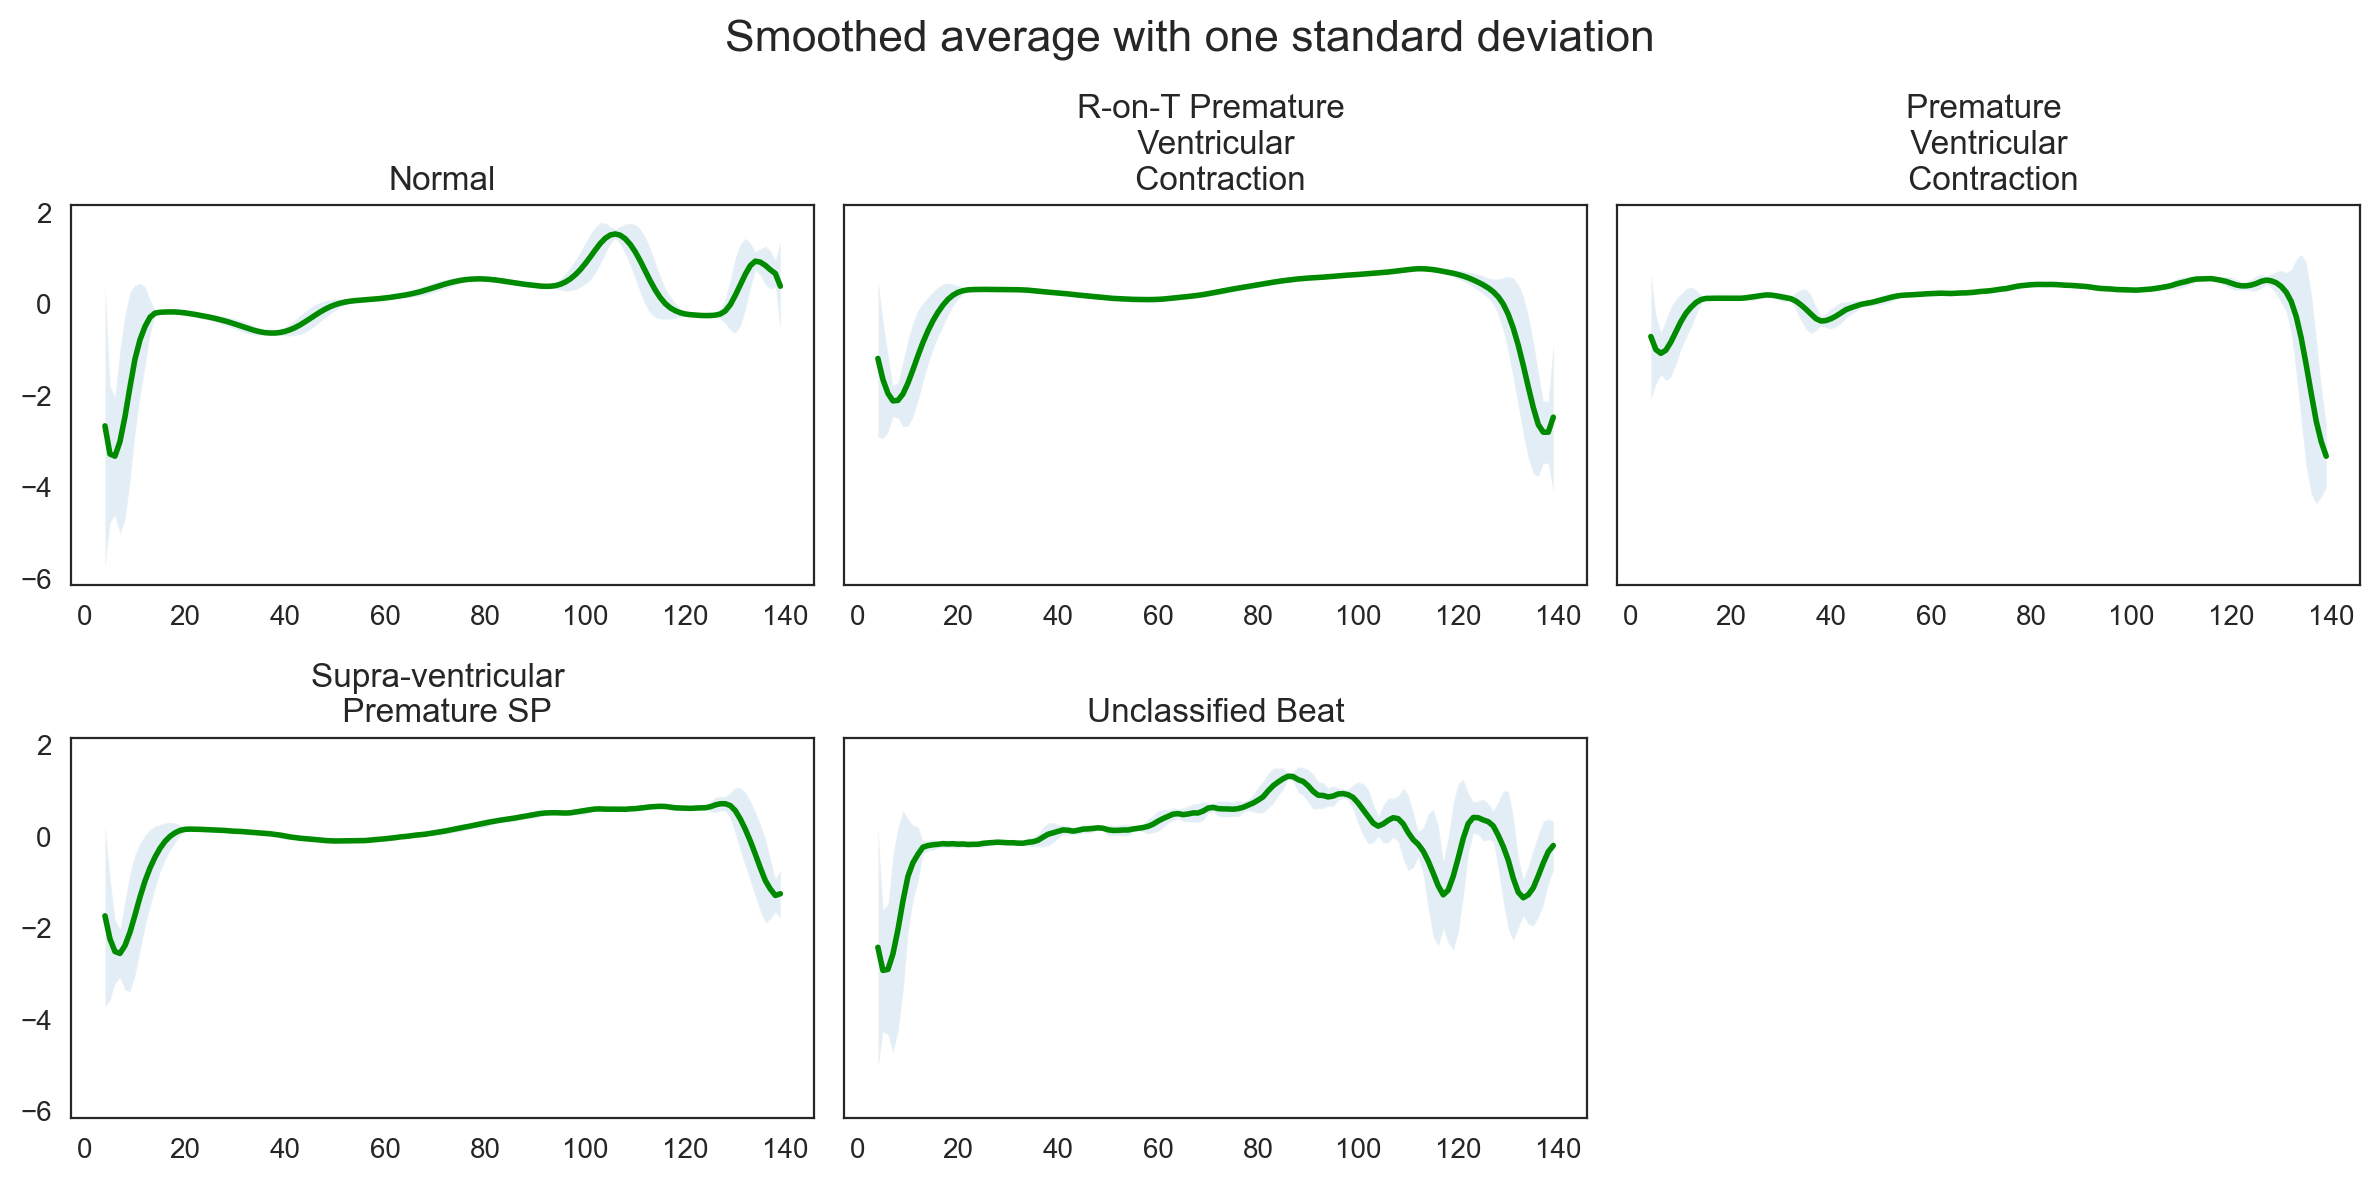

In [141]:
classes = train_df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(12, 6)
)

for i, class_value in enumerate(classes):
  ax = axs.flat[i]
  data = train_df[train_df.target == class_value].drop(labels='target', axis=1).mean(axis=0).to_numpy()
  class_analysis(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
plt.suptitle('Smoothed average with one standard deviation', size=16)
fig.tight_layout()

In [142]:
# Anomaly detection
normal_df = train_df[train_df['target'] == class_normal]
# Merge all abnormal targets to anomalies
anomaly_df = train_df[train_df['target'] != class_normal]
print('Number of normal records: {} - Number of anomaly records: {}'.format(len(normal_df), len(anomaly_df)))

Number of normal records: 292 - Number of anomaly records: 208


For this particular case, we will train an AI model only on **normal** data, with the following ideas:
- By establishing a well-defined 'normal' pattern, we can rely on the model to detech subtle deviations and identify potential anomalies effectively. 
- Instead of only focusing on these four abnormal classes, we will likely also detect anomalies that have not been specified in the data. 

**Why use an LSTM autoencoder?** 

- Model Structure: An LSTM autoencoder is specifically designed to handle sequential data. The model consists of two main parts: an **encoder** LSTM network that compresses the input data into a lower-dimensional representation, and a **decoder** LSTM network that attempts to reconstruct the original input from this compressed representation.

- Training on Normal Data Only: During training, we use only normal (non-anomalous) data, which helps the autoencoder learn the typical patterns in the normal heartbeats. By observing only the normal heartbeats, the autoencoder can learn the relationships, dependencies, and variations that make up what is "normal" for the data.

- Reconstruction Error as an Anomaly Score: After training, when we input a sequence of heartbeat data, the autoencoder tries to reconstruct it based on its learned representation. For normal data, it should reconstruct the sequence well, resulting in a low reconstruction error. However, when an anomalous data sequence is fed into the model, the LSTM autoencoder typically struggles to accurately reconstruct it because this sequence differs significantly from the normal patterns it has learned. As a result, the reconstruction error (for this case the mean absolute error, but another distance metric could work as well) will be noticeably higher for anomalies.


A step-by-step overview of the process:

1. Training Phase: Train the LSTM autoencoder on normal data only.
The model learns to minimize the reconstruction error for normal sequences, effectively encoding the normal patterns within its network structure.
The reconstruction error for normal sequences becomes low, as the model learns the specific dependencies in the normal time-series data.
2. Detection Phase: Use the trained autoencoder on both normal and potential anomalous data.
For each sequence, compute the reconstruction error.
If the error is below a predefined threshold, the sequence is considered normal. If the error exceeds this threshold, the sequence is flagged as an anomaly.
The threshold can be chosen based on the distribution of reconstruction errors on a validation set of normal data.
3. Threshold Selection:
Determine the anomaly detection threshold based on the maximum reconstruction error observed on the normal validation set.
This threshold serves as a boundary: if the reconstruction error for a new sequence exceeds this boundary, it is likely to be an anomaly.

In [143]:
# Split the normal training examples into train and validation sets:
train_df, val_df = train_test_split(
    normal_df,
    test_size=0.10,
    random_state=seed
)

For this case, we will use the **PyTorch** framework.

In [144]:
# Convert to tensors
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(seq).unsqueeze(1).float() for seq in sequences]
    _, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

train_dataset, sequence_length, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
print('train_dataset size:', len(train_dataset))
print('val_dataset size:', len(val_dataset))

train_dataset size: 262
val_dataset size: 30


In [145]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        # Parameters for the input sequence and dimensions
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        # First LSTM layer: encodes the input features into a hidden representation
        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        # Second LSTM layer: reduces the hidden representation down to the embedding dimension
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
    # The forward pass is the process of passing input data through the layers of the model to get an output
    def forward(self, x):
        # Reshape the input to have a batch size of 1
        x = x.reshape((1, self.seq_len, self.n_features))

        # Pass data through the first LSTM layer
        x, (_, _) = self.rnn1(x)
        # Pass output of first layer through the second layer to get the embedding
        x, (hidden_n, _) = self.rnn2(x)
        # Reshape embedding to the expected output dimensions
        return hidden_n.reshape((self.n_features, self.embedding_dim))
  
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        # Parameters for the input sequence and dimensions
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        # First LSTM layer: operates on the encoded representation
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )

        # Second LSTM layer: expands hidden representation to match input dimensions
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        # Output layer: matches n_features of the original input
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):

        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        # Instantiate encoder and decoder with specified sequence length, feature dimensions, and embedding size
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        # Pass input through encoder to get the embedding
        x = self.encoder(x)
        # Pass embedding through decoder to reconstruct the original input
        x = self.decoder(x)
        return x

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(sequence_length, n_features)

model = RecurrentAutoencoder(seq_len=sequence_length, n_features=n_features)
model = model.to(device)

cuda
141 1


In [147]:
# Training
def train_model(model, train_dataset, val_dataset, n_epochs):

    # Settings for the training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    # Training loop
    for epoch in range(1, n_epochs+1):
        train_losses = []
        model.train()
        
        for seq_true in train_dataset:

            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print('Epoch {}: train loss {} val loss {}'.format(epoch, train_loss, val_loss))

    model.load_state_dict(best_model_wts)
    return model.eval(), history

# Run training script
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=200
)

Epoch 1: train loss 82.69350801715414 val loss 72.77725512186686
Epoch 2: train loss 88.85371302830355 val loss 85.3824956258138
Epoch 3: train loss 68.7734160386879 val loss 60.30558547973633
Epoch 4: train loss 58.14956440816399 val loss 55.47215194702149
Epoch 5: train loss 56.91992181676035 val loss 57.16113204956055
Epoch 6: train loss 55.83914107402772 val loss 52.82743428548177
Epoch 7: train loss 54.8812715952633 val loss 53.349165725708005
Epoch 8: train loss 53.94110491803584 val loss 51.66113408406576
Epoch 9: train loss 54.03438659842688 val loss 53.103546396891275
Epoch 10: train loss 53.50830107244826 val loss 51.67834002176921
Epoch 11: train loss 53.67014053577685 val loss 50.84064585367839
Epoch 12: train loss 53.755213671968185 val loss 53.837001673380534
Epoch 13: train loss 53.40880242558836 val loss 51.53970947265625
Epoch 14: train loss 54.27516488810532 val loss 52.54717597961426
Epoch 15: train loss 53.33850738292432 val loss 51.583068974812825
Epoch 16: train l

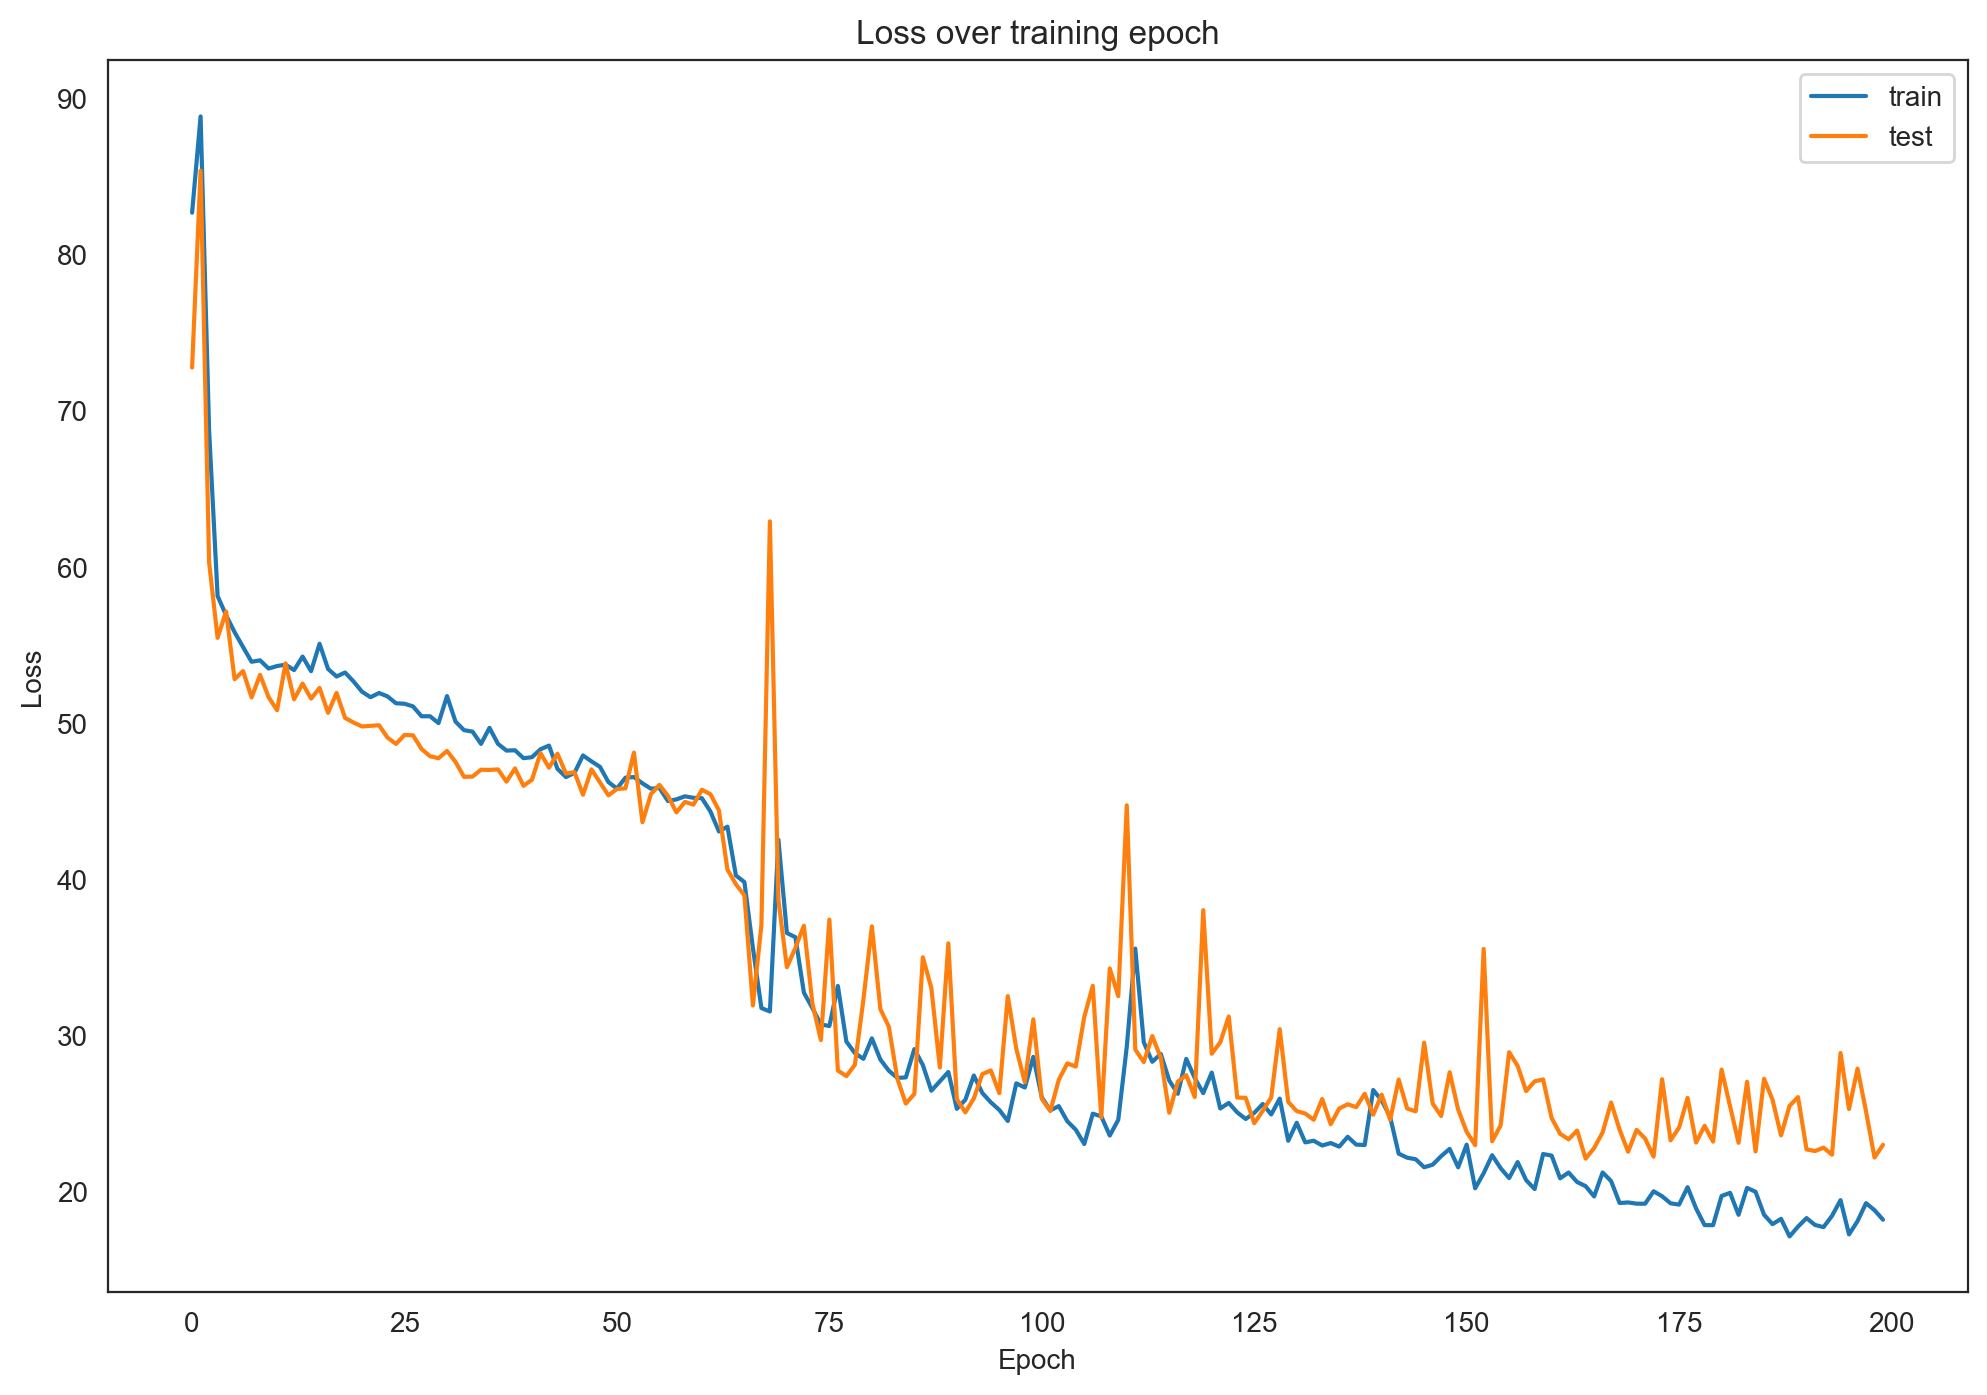

In [148]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epoch')
plt.show()

Now we are ready to analyze the results, and find a threshold for the reconstruction loss. This threshold will define the classification between normal and anomaly: Results with reconstruction loss **lower** than the threshold will be considered normal, and results with reconstruction loss **higher** than will be marked as anomalies

In [149]:
# Create a function for predictions
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
        
    return predictions, losses

In [150]:
# Divide the testing dataset into normal and anomaly classes
test_normal_df = test_df[test_df['target'] == class_normal]
test_anomaly_df = test_df[test_df['target'] != class_normal]
print('Normal test dataset size:', test_normal_df.shape)
print('Anomaly test dataset size:', test_anomaly_df.shape)

Normal test dataset size: (2627, 141)
Anomaly test dataset size: (1873, 141)


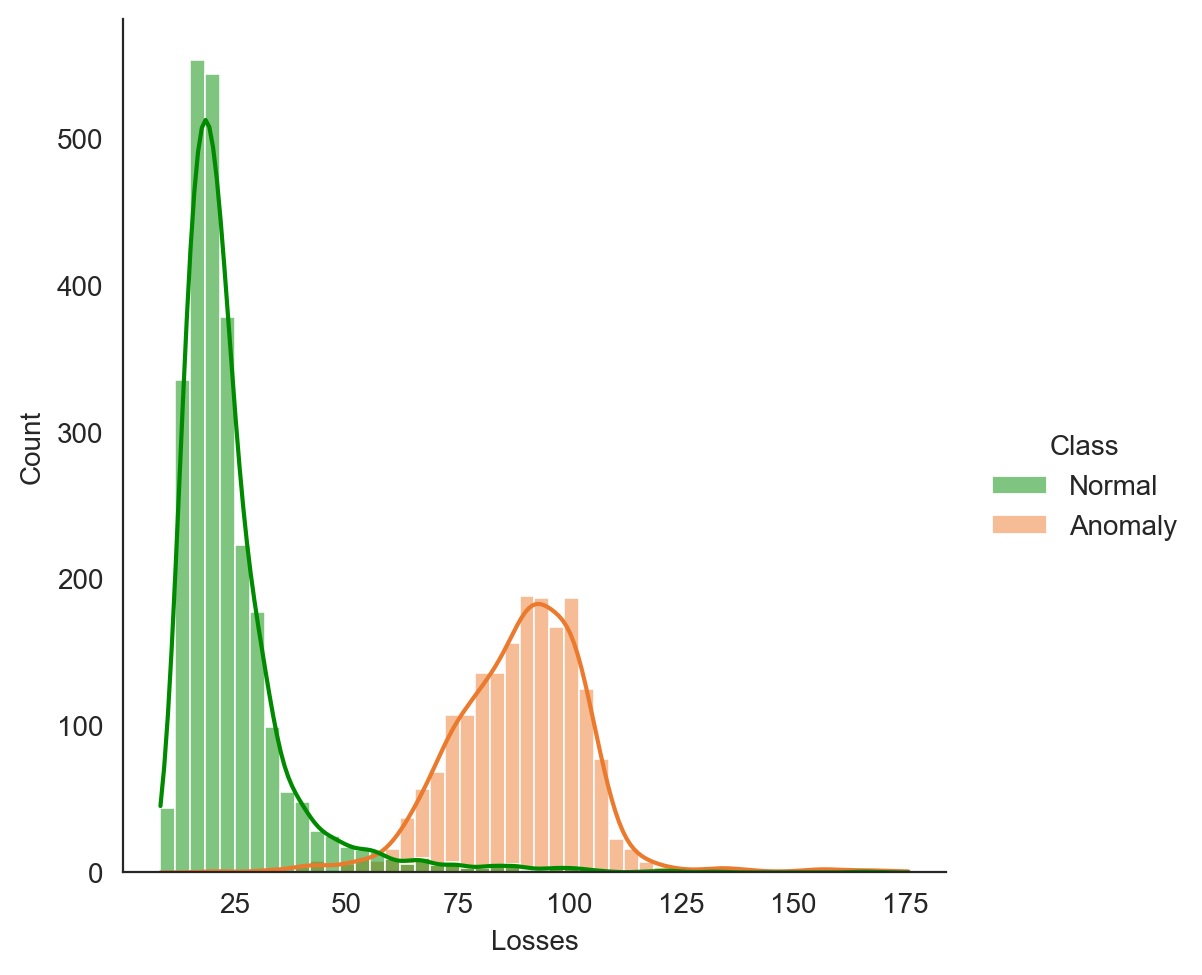

In [151]:

test_normal_dataset, _, _ = create_dataset(test_normal_df)
test_anomaly_dataset, _, _ = create_dataset(test_anomaly_df)

# Normal dataset is larger, retrieve subset of same length as anomaly dataset
# test_normal_dataset = test_normal_dataset[:len(test_anomaly_dataset)]
# test_anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
# Create a figure with two subplots that share the x-axis

normal_predictions, normal_losses = predict(model, test_normal_dataset)
anomaly_predictions, anomaly_losses = predict(model, test_anomaly_dataset)

data = pd.DataFrame({
    'Losses': normal_losses + anomaly_losses,
    'Class': ['Normal'] * len(normal_losses) + ['Anomaly'] * len(anomaly_losses)
})

sns.displot(data, x='Losses', hue='Class', bins= 50, palette=['#008A00', '#EC7A2E'], kde=True)

In [152]:
threshold = 60

Correct normal predictions: 2559/2627 - percentage 97.41
Correct anomaly predictions: 1822/1873 - percentage 97.28


C:\Users\ersav\AppData\Local\Temp\ipykernel_11992\4077181698.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Normal', 'Anomaly'])
C:\Users\ersav\AppData\Local\Temp\ipykernel_11992\4077181698.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Normal', 'Anomaly'])


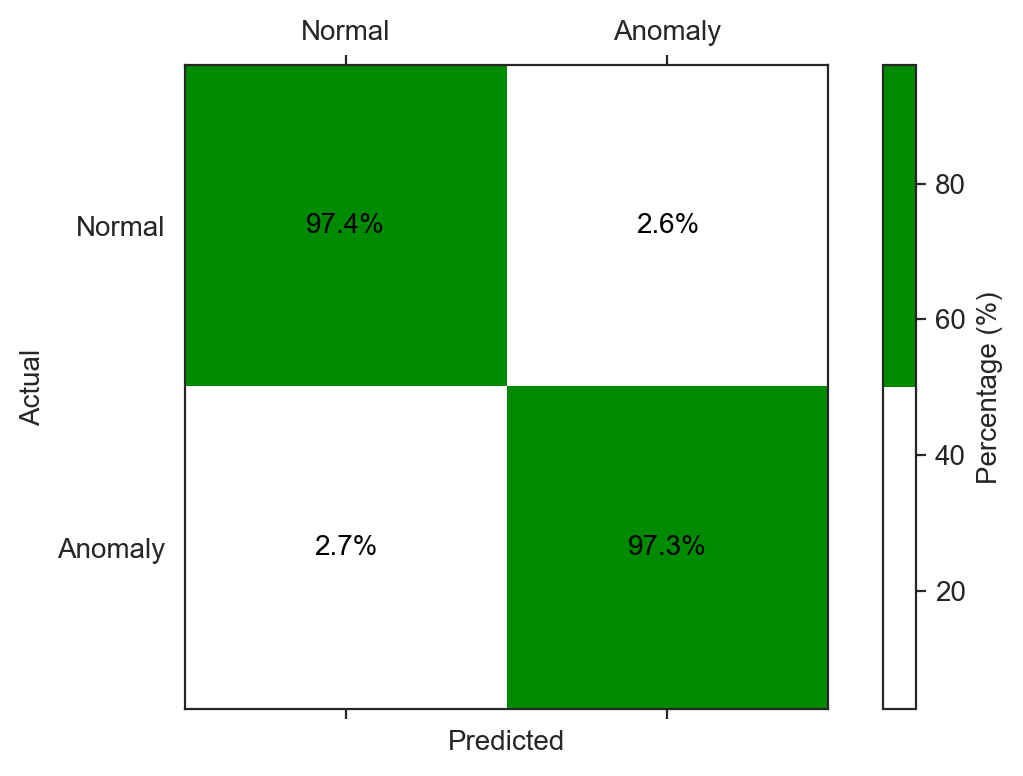

In [162]:
correct_normal = sum(l <= threshold for l in normal_losses)
false_normal = sum(l > threshold for l in normal_losses)
print('Correct normal predictions: {}/{} - percentage {}'.format(correct_normal, len(test_normal_dataset), np.round(correct_normal / len(test_normal_dataset)* 100, 2)))

correct_anomaly = sum(l > threshold for l in anomaly_losses)
false_anomaly = sum(l <= threshold for l in anomaly_losses)
print('Correct anomaly predictions: {}/{} - percentage {}'.format(correct_anomaly, len(test_anomaly_dataset), np.round(correct_anomaly / len(test_anomaly_dataset)* 100, 2)))

results = [
    'correct normal', 
    'false normal', 
    'correct anomaly', 
    'false anomaly'
]
result_values = np.array([
    [
        correct_normal / len(test_normal_dataset), 
        false_normal /  len(test_normal_dataset)
    ], 
    [
        false_anomaly / len(test_anomaly_dataset),
        correct_anomaly / len(test_anomaly_dataset)
    ]
]) * 100
# Create a heatmap
fig, ax = plt.subplots(figsize=(6, 4))
cmap = plt.cm.colors.ListedColormap(['white', '#008A00'])
cax = ax.matshow(result_values, cmap=cmap)

# Annotate the heatmap with percentage values
for (i, j), val in np.ndenumerate(result_values):
    ax.text(j, i, f'{val:.1f}%', ha='center', va='center', color='black')

# Set axis labels and ticks
ax.set_xticklabels(['', 'Normal', 'Anomaly'])
ax.set_yticklabels(['', 'Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar(cax, label='Percentage (%)')

# Show the plot
plt.tight_layout()
plt.show()

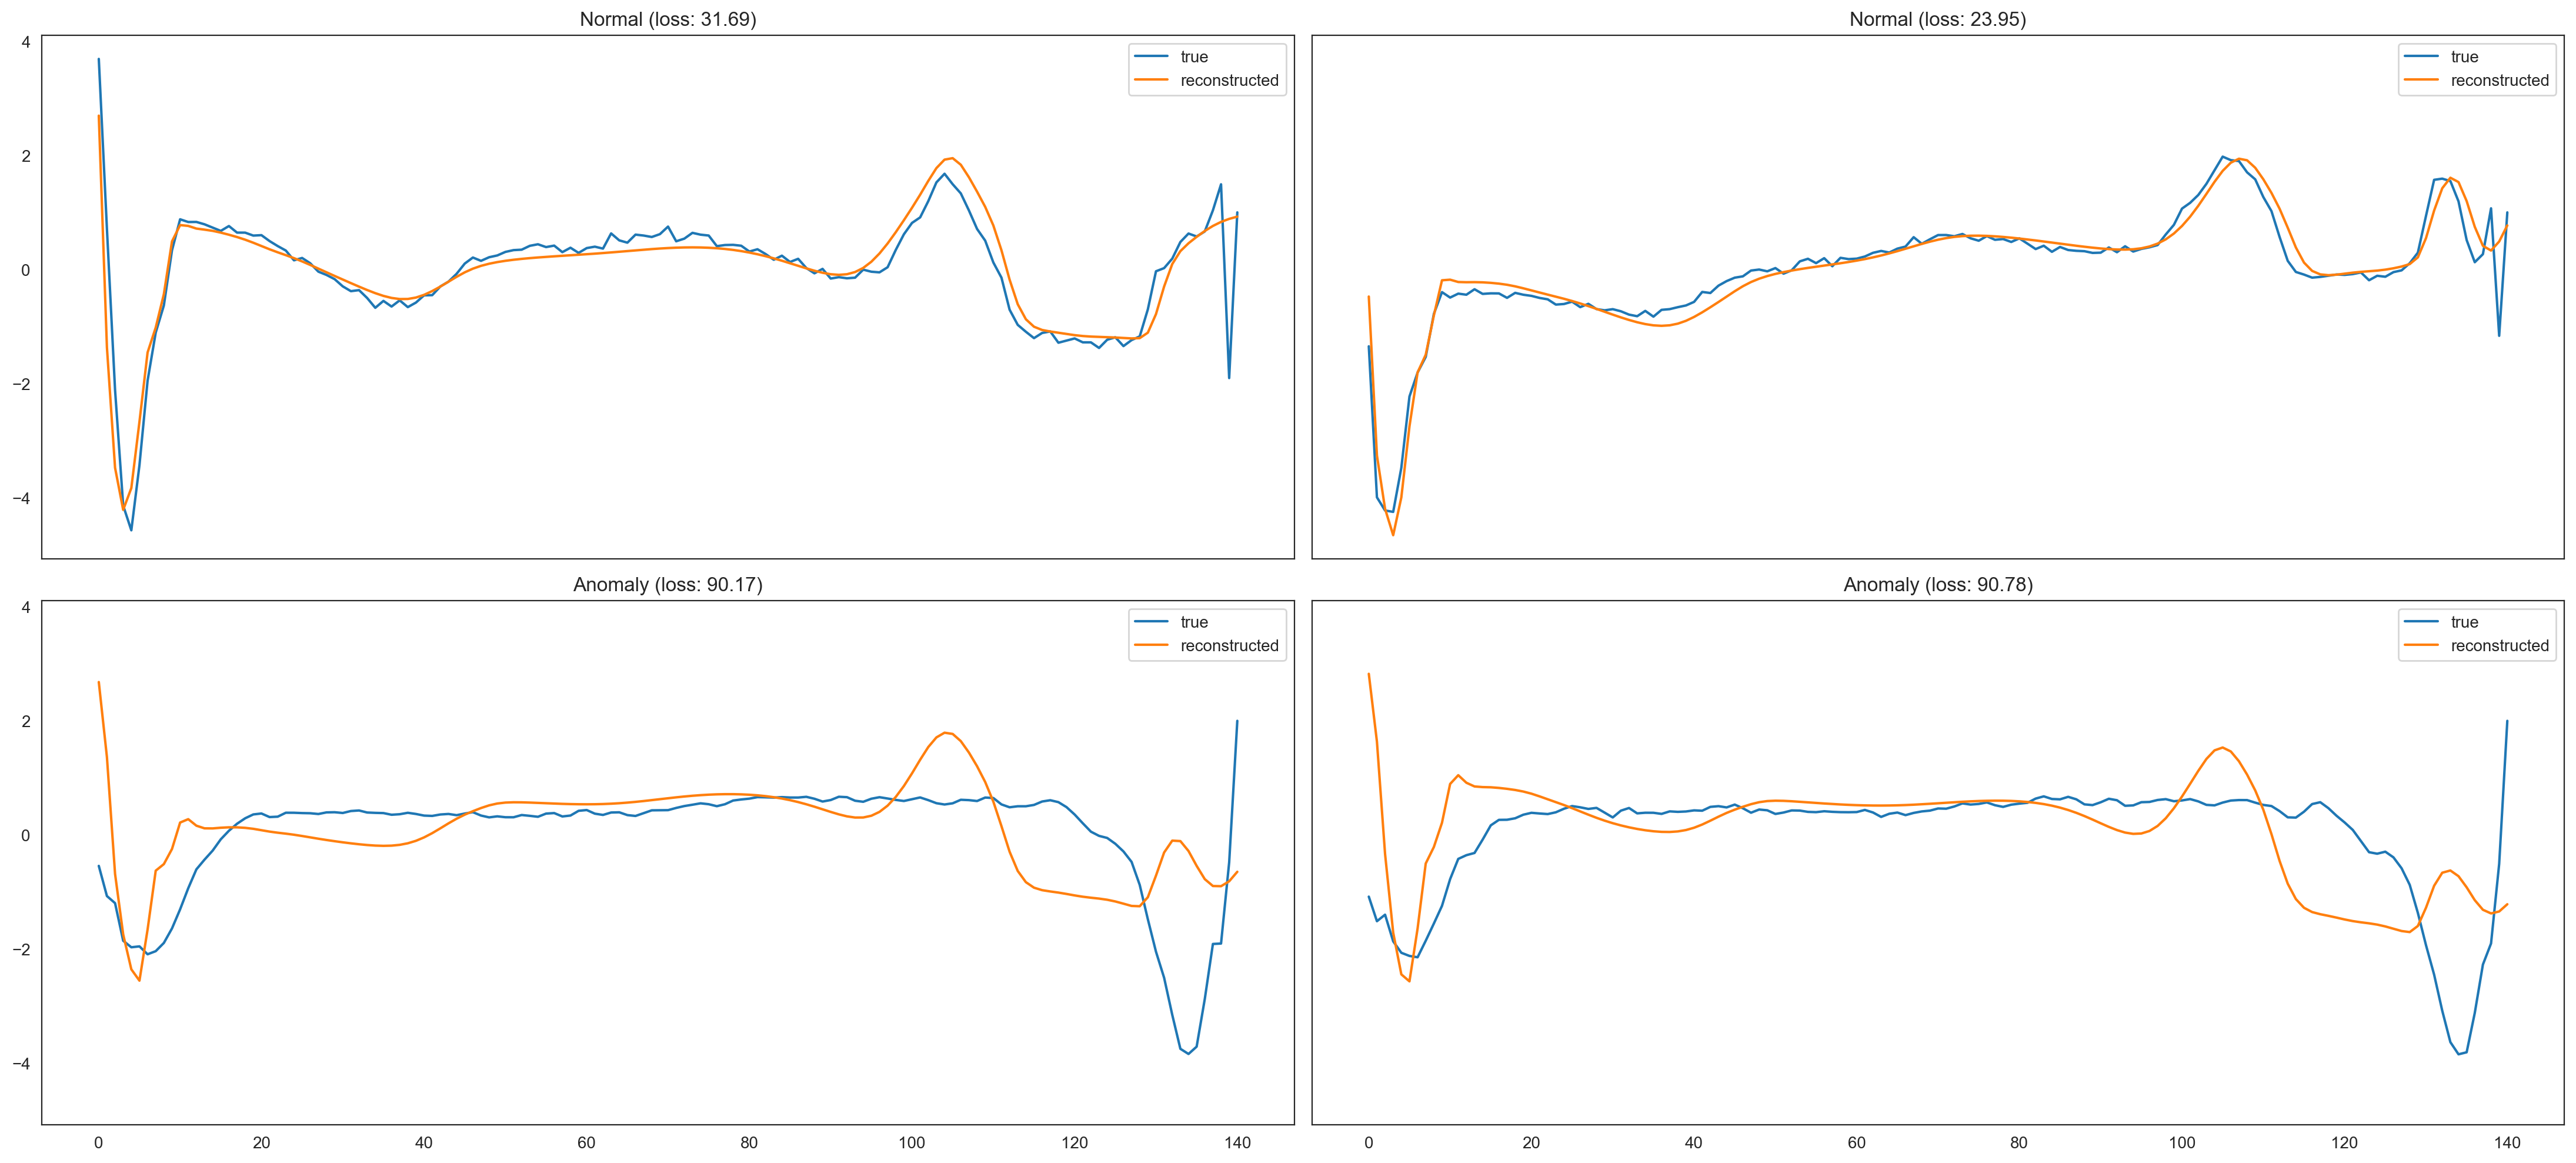

In [163]:
# Overlay real and constructed time series data for comparison

def plot_predictions(data, model, title, ax):
    predictions, losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title('{} (loss: {})'.format(title, np.around(losses[0], 2)))
    ax.legend()
n = 2
fig, axs = plt.subplots(2, n, sharey=True, sharex=True, figsize=(22,10))

for i, data in enumerate(test_normal_dataset[:n]):
    plot_predictions(data, model, title='Normal', ax=axs[0,i])
for j, data in enumerate(test_anomaly_dataset[:n]):
    plot_predictions(data, model, title='Anomaly', ax=axs[1,j])
fig.tight_layout()